<a href="https://colab.research.google.com/github/FANTASY000666/Reviews_classifier/blob/main/Review_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
!pip install git+https://github.com/newrelic-experimental/ml-performance-monitoring.git

  Cloning https://github.com/newrelic-experimental/ml-performance-monitoring.git to /tmp/pip-req-build-lxf38wy2
  Running command git clone --filter=blob:none --quiet https://github.com/newrelic-experimental/ml-performance-monitoring.git /tmp/pip-req-build-lxf38wy2
  Resolved https://github.com/newrelic-experimental/ml-performance-monitoring.git to commit b2e516a86d771d7c442642ae045648c5f292ed24
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from ml_performance_monitoring.monitor import MLPerformanceMonitoring

In [ ]:
metadata = {'environment': 'notebook'}
model_version = "1.0"
features_columns, labels_columns = (
  ['feature_1', 'feature_2', 'feature_3'],
  ['target'],
)

ml_monitor = MLPerformanceMonitoring(
    insert_key="1d0be1792d94ebce971fad2f026f31a2FFFFNRAL",  # set the environment variable NEW_RELIC_INSERT_KEY or enter your insert key here
    model_name="BTC",
    metadata=metadata,
    features_columns=features_columns,
    labels_columns=labels_columns,
    event_client_host="insights-collector.newrelic.com",
    metric_client_host="metric-api.newrelic.com",
    model_version=model_version
)

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)
sample_file = os.path.join(train_dir, 'pos/1000_8.txt')
with open(sample_file) as f:
  print(f.read())

I liked the film. Some of the action scenes were very interesting, tense and well done. I especially liked the opening scene which had a semi truck in it. A very tense action scene that seemed well done.<br /><br />Some of the transitional scenes were filmed in interesting ways such as time lapse photography, unusual colors, or interesting angles. Also the film is funny is several parts. I also liked how the evil guy was portrayed too. I'd give the film an 8 out of 10.


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')

In [ ]:
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
print("Label 0 ni ", raw_train_ds.class_names[0])
print("Label 1 ni ", raw_train_ds.class_names[1])

Label 0 ni  neg
Label 1 ni  pos


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset = 'validation',
    seed = seed
    )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_Length = 250
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_Length
)

In [ ]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retieve a batch of 32 reviews and labels
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))



Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
print("1021 ---> ",vectorize_layer.get_vocabulary()[260])


1021 --->  especially


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs =10
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 16s 22ms/step - loss: 0.6634 - binary_accuracy: 0.6955 - val_loss: 0.6146 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5489 - binary_accuracy: 0.7999 - val_loss: 0.4985 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4447 - binary_accuracy: 0.8456 - val_loss: 0.4202 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3781 - binary_accuracy: 0.8660 - val_loss: 0.3737 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3349 - binary_accuracy: 0.8789 - val_loss: 0.3449 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3047 - binary_accuracy: 0.8895 - val_loss: 0.3257 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 5s 8ms/

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss*100)
print("Accuracy: ", accuracy*100)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - binary_accuracy: 0.8728
Loss:  31.05156123638153
Accuracy:  87.2759997844696


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

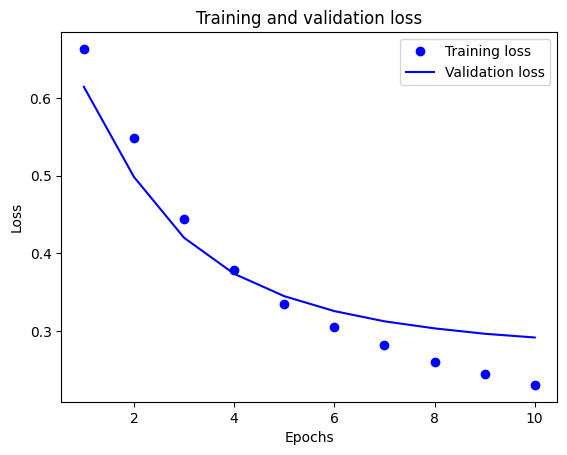

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

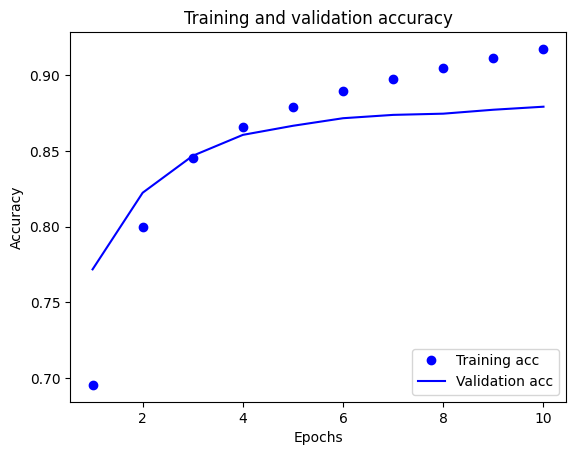

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - accuracy: 0.8728
0.872759997844696


In [ ]:
examples = [
  "The movie was very very great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 131ms/step


array([[0.6794044 ],
       [0.42673185],
       [0.34769213]], dtype=float32)

In [ ]:
# Preprocess the examples using the vectorize_layer
import numpy as np
import pandas as pd
# Preprocess the examples using the vectorize_layer
numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

numerical_examples = pd.DataFrame(numerical_examples)

ml_monitor.record_inference_data(numerical_examples, predictions)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

1/1 [==============================] - 0s 56ms/step
Sentence: 'The movie was very very great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
1/1 [==============================] - 0s 21ms/step
inference data sent successfully
Sentence: 'The movie was very very great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
